In [1]:
import glob
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

from IPython import display as ipd
from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder,  DatasetFolder,VisionDataset
from sklearn.model_selection import train_test_split
import os
import torchvision.models as models

%matplotlib inline
warnings.filterwarnings("ignore")

import torchaudio
#from pydub import AudioSegment
from IPython import display

In [2]:
class CFG:
    JUST_PREDICT  = False
    Kaggle        = False 
    DEBUG         = False
    FULL_DATA     = True
    wandb_on      = False
    seed          = 101
    MULTIMODEL    = False
    weights       = 'imagenet'
    backbone      = 'efficientnet-b1'
    archive_name  = 'Audio'
    models        = []
    optimizers    = []
################################################### 
    num_of_models = 1
    model_number  = 1
    train_bs      = 1
    valid_bs      = 1
    SAMPLE_RATE = 22050
    NUM_SAMPLES = 22050
    number_imgs   = 10 if DEBUG else 649     #8203
    num_test      = 10 if DEBUG else 301      # 1000
    print_every   = 1  if DEBUG else 50      #500
    img_size      = [512, 512] #[540, 960] #(1624, 1232)
    start_width   = 1024
    start_height  = 1024
    final_width   = 800
    final_height  = 800
    epochs        = 2  if DEBUG else 16        #35
    ###############################################
    crop_koef     = 1
    lr            = 0.002
    num_workers   = 4 if Kaggle else 0
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 2
    classes       = [0,1]
    activation    = None #'softmax'
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    images_path   = "../input/russian-railways-2/images/images/" if Kaggle else "../../Desktop/hack/image"
    masks_path    = "../input/russian-railways-2/mask/mask/" if Kaggle else  "../../Desktop/hack/masks"
    test_path     = "../input/russian-railways-2/test/test/" if Kaggle else "./test/"
    save_path     = '../working/result/' if Kaggle else "./result/"
    train_path    = './train/'
    best_model_w  = '../input/russian-railways-2/best_epoch_ofu-efficientnet-b4_v2.bin' if Kaggle else f'./best_epoch_ofu-{backbone}_v2.bin'


# Audio Instalations

In [3]:
#!pip install pydub

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [5]:
#waveform, sample_rate = torchaudio.load('./train/000ad36ce0dcbc1032a606312d5e787d.wav')

In [6]:
#display.Audio(waveform, rate = sample_rate)

In [7]:
#waveform.size()[0]

In [8]:
#Mel_Spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)

In [9]:
#Mel_Spectrogram.shape

In [10]:
#!pip install PySoundFile

In [11]:
# Different classes dataset. 
classes = ('0','1')

In [12]:
data_path = './targets.tsv' #'../YandexML_TEST/targets.tsv'
train_path = './train/'
data = pd.read_csv(data_path, sep = '\\t', header=None)

In [13]:
data.head()

,0,1
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0


In [14]:
#from torchaudio.io import StreamReader
from IPython import display

In [15]:
audio_ids = list(data[1])
audio_names = list(data[0])
print(audio_ids)

[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 

In [16]:
class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples):
        self.annotations = annotations_file
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.audio_dir)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = signal.repeat(3, 1, 1)
        signal = torch.squeeze(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = self.audio_dir[index]
        path = CFG.train_path + path
        print(path)
        return path

    def _get_audio_sample_label(self, index):
        path = self.audio_dir[index]
        print(path)
        path= path.split('.')[0]
        #path = '.'+ path
        print(f'Hi ---- {path}')
        list_hui = torch.tensor(list(self.annotations[self.annotations[0] == path][1]))
        return list_hui




In [17]:
def prepare_loaders():
    
    audio_names= [item_name for item_name in os.listdir(CFG.train_path)]
    print(audio_names)
    audio_train_valid, audio_test = train_test_split(audio_names, test_size=0.2 , random_state=42)
    audio_train, audio_valid = train_test_split(audio_names, test_size=0.25 , random_state=42)
    #print(type(train_ids))
    #print(valid_ids)
    train_dataset = UrbanSoundDataset(data, audio_train, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES)
    valid_dataset = UrbanSoundDataset(data, audio_valid, mel_spectrogram, CFG.SAMPLE_RATE, CFG.NUM_SAMPLES)
    
    train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=1, num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

## Audio Augmentations

In [18]:

# transformations = transforms.Compose(
#     ProcessChannels(mode=avg)
#     AdditiveNoise(prob=0.3, sig=0.001, dist_type=normal)
#     RandomCropLength(prob=0.4, sig=0.25, dist_type=half)
#     ToTensorAudio()
# )
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=CFG.SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)



     

In [19]:
train_loader, valid_loader = prepare_loaders()

['0006238dc99eaf68957dfc81826d1071.wav', '0007b9d41374f46f25cb35f13dc97e5e.wav', '000ad36ce0dcbc1032a606312d5e787d.wav', '0012112033f3f6c687c003cee20d0ba2.wav', '00122174f87c115e13f69cd685477387.wav', '00128d3dbe40482e69fa7115a108e122.wav', '0012de492fe2a5811bcc36371ad3a13f.wav', '001418d720f3f38e88a74dff39c46268.wav', '001468e989edc7827ffec11713645524.wav', '0017f6feabf9303491f4febb51584f26.wav', '001b54ffa084b57093556010a3305159.wav', '0028c04ae576ddc0dfe357da4da596fc.wav', '0029693e37fe5ca77db17e9dd1d96fb6.wav', '002dfb1fe7d4e0e6b5f28a319d70710f.wav', '0033060813158cb544cf316e90d548a9.wav', '003859f64e73128077757dce1ff4537e.wav', '003a9c4f16e460333d1cc88f7306ef9d.wav', '003e2ca98923056b62387176de55367d.wav', '0041770a63b3efdc216bcd1ebdd92978.wav', '004767ae215d953afd8f0cc8b5bbf3d6.wav', '004a909feabe027e273228436fb328ca.wav', '004b4cad0e5f2f8dda822a01a6d160ff.wav', '004c286a6ee77276e877d5fdf184fb0a.wav', '004ca8005f2e843a0e51eae7c4623021.wav', '0053e0e1b4fde6f20e662acaf77ed930.wav',

## Efficientnet

In [20]:
#!pip install --upgrade efficientnet-pytorch

In [21]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b1'
model = EfficientNet.from_pretrained(model_name)  #, num_classes=3
model.eval()
#model

Loaded pretrained weights for efficientnet-b1


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [22]:
# # Чтобы заморозить параметры на всех слоях

# for param in model.parameters():
#     param.requires_grad = False 

In [23]:
model._fc = torch.nn.Sequential(
    nn.Linear(in_features=1280, out_features=625, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=625, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=2, bias=True))
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [24]:
# PATH = "../input/woodhack-hackathon/effnetb7.pth"
# model.load_state_dict(torch.load(PATH))
# model.eval()


# Model Summary

In [25]:
#!pip install torch-summary

In [26]:
# from torchsummary import summary
# model.to(device)
#summary(model, input_size = (3,224,224))

In [27]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cpu",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step() #step - обновление весов модели
            optimizer.zero_grad() #zero_grad - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) ~ for each param in params: param.grad = None
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description( 
                f"Loss: {round(loss.item(), 4)} " # .item - from tensor to python number
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda"):
    model = model.eval() # выключает некоторые слои при подсчете
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout, unit = "batch") as prbar: # pregress bar
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics


In [28]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda"
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses) # добавляет в конец списка как отдельные элементы
        epoch_train_losses.append(train_metrics["loss"]) # добавляет в конец список как список
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"]) # добавляет в конец список как список

## Fit EfficientNet

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
EPOCH = 25
print(device)

cpu


In [30]:
def Melspectrogram_visualize(array: torch.Tensor):
    array = torch.squeeze(array)
    print(array.shape)
    array = array.permute(2,1,0) * 1000
    print(array.shape)
    print(array)
    img = array.numpy().astype(np.uint8)
    print(type(img))
    print(img.shape)
    img = Image.fromarray(img)
    
    imgplot=plt.imshow(img)
    plt.show()
    
    
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [31]:
audio, Class = next(iter(train_loader))
print(audio.shape)
print(Class)

./train/952f04b91f12b11533c6f37d63c31010.wav
952f04b91f12b11533c6f37d63c31010.wav
Hi ---- 952f04b91f12b11533c6f37d63c31010
torch.Size([1, 3, 64, 44])
tensor([[1]])


torch.Size([3, 64, 44])
torch.Size([44, 64, 3])
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        ...,

        [[2.3540e+00, 2.3540e+00, 2.3540e+00

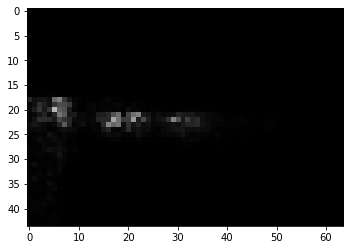

In [32]:
Melspectrogram_visualize(audio)

In [33]:
#Torch_array_Image_print(audio)

In [34]:
fit(model, EPOCH , train_loader, valid_loader, optimizer, criterion, device=device)

Train Epoch: 0


  0%|          | 0/10452 [00:00<?, ?it/s]

./train/2c68df105336e51b58351d0b4e8c9e8e.wav
2c68df105336e51b58351d0b4e8c9e8e.wav
Hi ---- 2c68df105336e51b58351d0b4e8c9e8e


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

## Сохранение модели

## Efficcient_net

In [ ]:
# PATH = "effnetb7.pth"
# os.chdir("/kaggle/working/")
# torch.save(model.state_dict(), PATH ) #state_dict - получить текущее состояние Optimizer. Для адаптивных методов тут будут храниться аккумулированные квадраты градиентов

## Efficcient_net predict

In [ ]:
test = []
img_names= [ os.path.join("../input/senyakletka/image/test",img_name) for img_name in os.listdir('../input/senyakletka/image/test/')]
for i in range(1,82):
    path = img_names[i]
    #path = "../input/neurowood/testset/" + str(i) + '.jpg'
   #else:
        #path = "../input/woodhack/test1/test/" + str(i) + '.JPG'
    img = Image.open(path)
    #plt.imshow(img)
    img = transformations(img)
    img = img[None, :]
    img = img.to(device)
    predicted = model(img)
    #print(predicted,img.size())
    _, pred = torch.max(predicted, 1)
    test.append(classes[pred.item()])
print(test)

In [ ]:
df = pd.DataFrame({"id" : range(1,82),
                   "eff": test
        
                  })

In [ ]:
#df['rez'] = df.mode(axis='columns')[0]

In [ ]:
df.head(60)

In [ ]:
df.tail(60)

In [ ]:
# df['sum'] = df['eff'] + df['res50'] + df['vgg19']
# df['sum'] = df['sum'].map({1:0, 0:0, 2:1, 3:1})
ansamble_pred = df['rez'].to_numpy()

In [ ]:
df = pd.DataFrame({"id" : range(1,250),
                   "class": ansamble_pred
                  })

In [ ]:
# df = pd.DataFrame({"id" : range(1,250),
#                    "class": test
#                   })

In [ ]:
# df["class"]

In [ ]:
df.tail(50)

In [ ]:
# df_full.tail(50)

In [ ]:
print('Generating submission file...')
#os.chdir("./")
df.to_csv('submission_audio.csv',index=False)

In [ ]:
# df_full.to_csv('submission_effnet7new2.csv',index=False)